In [139]:
import sys
#import matplotlib.pyplot as plt
#import numpy as np
%pylab inline
from __future__ import print_function


T = 50
start_ind = 0
F = np.eye(4)
delta_t = 0.1
F[0,2] = delta_t
F[1,3] = delta_t
Q = 0.001*np.eye(4)
R = np.array([1,0,0,50]).reshape(2,2)
B = np.array([0, -0.5*delta_t**2,0,-delta_t]).reshape(4,1)
u = 9.8
H = np.array([1,0,0,0,0,1,0,0]).reshape(2,4)
dot_size = 10 #for plotting
custom_figsize = (15,7)
print('F:\n{}\nB:\n{}\nu:\n{}\nQ:\n{}\nR:\n{}\nH:\n{}\n'.format(F,B,u,Q,R,H))

Populating the interactive namespace from numpy and matplotlib
F:
[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
B:
[[ 0.   ]
 [-0.005]
 [ 0.   ]
 [-0.1  ]]
u:
9.8
Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]
R:
[[ 1  0]
 [ 0 50]]
H:
[[1 0 0 0]
 [0 1 0 0]]



The model is:
$$
X_k = FX_{k-1} + Bu + w_k, \text{where w_k from N(0,Q)} \\
Y_k = HX_{k} + v_k, \text{where v_k from N(0,R)}
$$

Kalman filter:
1. Initialization
    * $\hat{X}_{1|0} = \mu_0$
    * $\Sigma_{1|0} = \Sigma_0$
2. Prediction
    * $\hat{X}_{k|k-1} = F\hat{X}_{k-1|k-1} + BU$
    * $\Sigma_{k|k-1} = F\Sigma_{k-1|k-1}F^T + Q$
3. Filtration
    * $\hat{Y}_k = Y_k - H\hat{X}_{k|k-1}$
    * $S_k = R + H\Sigma_{k|k-1}H^T$
    * $K_k = \Sigma_{k|k-1}H^TS_k^{-1}$
    * $\hat{X}_{k|k} = \hat{X}_{k|k-1} + K_k\hat{Y}_k$
    * $\Sigma_{k|k} = \Sigma_{k|k-1} - K_kH\Sigma_{k|k-1}$

In [168]:
def mse(v1,v2):
    return np.mean(np.sum((v1-v2)**2,axis=0))


def generate_trajectory(T, starting_point):
    X = np.array(starting_point).reshape(4,1)
    Y = np.array(starting_point[:2]).reshape(2,1)

    xs = np.empty((4,T))
    for i in range(T):
        xs[:,i, None] = np.array(X)
        w = np.random.multivariate_normal(np.zeros(4), Q, 1).reshape(4,1)
        X = np.dot(F,X) + np.dot(B,u) + w

    err = np.random.multivariate_normal(np.zeros(2), R, T).T
    ys = np.dot(H,xs) + err
    return xs,ys
    
def kalman_filter(ys, starting_point, Q, R):
    kalman_xs = np.zeros((4,T),dtype=np.float64)
    kalman_xs[:,0] = np.array(starting_point,dtype=np.float64)
    kalman_xs_filtered = np.zeros((4,T),dtype=np.float64)
    kalman_xs_filtered[:,0] = np.array(starting_point,dtype=np.float64)
    kalman_covs = np.zeros((4,4,T),dtype=np.float64)
    kalman_covs_filtered = np.zeros((4,4,T),dtype=np.float64)
    kalman_covs[:,:,0] = np.zeros_like(Q)
    kalman_covs_filtered[:,:,0] = np.zeros_like(Q)
    kalman_s = np.zeros((2,2),dtype=np.float64)
    kalman_k = np.zeros((4,2),dtype=np.float64)
    kalman_y = np.zeros((2,1),dtype=np.float64)
    
    kalman_x = np.array(kalman_xs[:,0]).reshape(4,1)
    kalman_cov = np.array(kalman_covs[:,:,0])

    for i in range(1,T):
        #prediction step
        kalman_x = np.dot(F,kalman_x) + np.dot(B,u)
        kalman_cov = np.dot(np.dot(F,kalman_cov),F.T) + Q
        print('Inside kalman\n', np.max(kalman_cov))
        
        #update #in our notation X_{i|i-1}
        kalman_xs[:,i, None] = np.array(kalman_x)
        kalman_covs[:,:,i] = np.array(kalman_cov)
        
        #filtering step
        kalman_y = ys[:,i, None] - np.dot(H, kalman_x)
        kalman_s = R + np.dot(np.dot(H,kalman_cov),H.T)
        kalman_k = np.dot(np.dot(kalman_cov, H.T), np.linalg.inv(kalman_s))
        kalman_x += np.dot(kalman_k, kalman_y)
        kalman_cov -= np.dot(np.dot(kalman_k, H), kalman_cov)
        # in our notation X{i|i}
        kalman_covs_filtered[:,:,i] = np.array(kalman_cov)
        kalman_xs_filtered[:,i,None] = np.array(kalman_x)
        
    return kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered
    
def rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered):
    rts_xs = np.zeros_like(kalman_xs, dtype=np.float64)
    rts_ls = np.zeros_like(kalman_covs, dtype=np.float64)
    rts_covs = np.zeros_like(kalman_covs, dtype=np.float64)
    rts_xs[:,T-1,None] = np.array(kalman_xs[:,T-1,None])
    rts_cov = kalman_covs[:,:,0]
    rts_l = np.zeros((4,4),dtype=np.float64)
    rts_x = np.array(kalman_xs[:,T-1,None])

    for i in range(T-2,-1,-1):
        cov_filtered = kalman_covs_filtered[:,:,i]
        cov = kalman_covs[:,:,i+1]
        rts_l = np.dot(cov_filtered, np.dot(F.T, np.linalg.inv(cov)))
        rts_x = kalman_xs_filtered[:,i,None] + np.dot(rts_l, rts_x - kalman_xs[:,i+1,None])
        rts_cov = cov_filtered + np.dot(rts_l, np.dot(rts_cov - cov, rts_l.T))
        
        #update - we will need it for EM
        rts_xs[:,i,None] = np.array(rts_x)
        rts_covs[:,:,i] = np.array(rts_cov)
        rts_ls[:,:,i] = np.array(rts_l)
        
    return rts_xs, rts_covs, rts_ls
    
def em_algorithm(ys, starting_point, max_steps, epsilon):

    Q = np.eye(4)
    #R = np.array([1,0,0,50]).reshape(2,2)#1000*np.eye(2)#5*np.random.randn(2,2)
    R = np.eye(2)
    Qs = np.zeros((4,4,max_steps+1))
    Rs = np.zeros((2,2,max_steps+1))
    Qs[:,:,0] = np.array(Q)
    Rs[:,:,0] = np.array(R)
    steps = 0
    diff = 1000
    while steps < max_steps and diff > epsilon: 
        prev_Q = np.array(Q)
        prev_R = np.array(R)
        kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered = kalman_filter(ys, starting_point, Q, R)
        rts_xs, rts_covs, rts_ls = rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered)
        print('Test old: ',np.max(kalman_covs), np.max(Q))
        old_rts_xs = np.array(rts_xs)
        rts_xs = rts_xs.reshape(4,1,T)
        kalman_xs = kalman_xs.reshape(4,1,T)
        kalman_xs_filtered = kalman_xs_filtered.reshape(4,1,T)
        new_ys = np.array(ys.reshape(2,1,T))
        # E(x_k | Y_{1:T})
        expected_xs = rts_xs
        # E(x_kx_k^t| Y_{1:t})
        expected_dot = np.einsum('ijk,ljk->ilk', rts_xs, rts_xs) + rts_covs
        # E(x_kx_{k+1}^T| Y_{1:T})
        tmp = np.einsum('ijk,jlk->ilk', rts_ls[:,:,:T-1], np.einsum('ijk,ljk->ilk', (rts_xs[:,:,1:] - kalman_xs[:,:,1:]), rts_xs[:,:,1:]) + rts_covs[:,:,1:])
        expected_dot_shift = np.einsum('ijk,ljk->ilk', kalman_xs_filtered[:,:,:T-1], rts_xs[:,:,1:]) +  tmp

        #####################
        # test for correctness of expected_doc_shift
        #ind = np.random.randint(0,T-1)
        #actual = np.dot(kalman_xs_filtered[:,:,ind], rts_xs[:,:,ind+1].T) + np.dot(rts_ls[:,:,ind], rts_covs[:,:,1+ind] + np.dot(rts_xs[:,:,1+ind]-kalman_xs[:,:,1+ind], rts_xs[:,:,1+ind].T))
        #print(actual)
        #print(expected_dot_shift[:,:,ind])
        #print(all(np.abs(actual - expected_dot_shift[:,:,ind]) < 10**-8))
        #####################
        
        tmp0 = (old_rts_xs[:,1:] - np.dot(F, old_rts_xs[:,:T-1]) - np.dot(B,u)).reshape(4,1,T-1)
        tmp1 = np.einsum('ijk,ljk->il', tmp0, tmp0)
        tmp2 = np.dot(F,np.einsum('ijk,jlk->il', rts_ls[:,:,:T-1], rts_covs[:,:,1:]))
        tmp3 = np.dot(F,np.dot(rts_covs[:,:,:T-1].sum(axis=2),F.T)) + rts_covs[:,:,1:].sum(axis=2)
        
        
        #ind = np.random.randint(0,T-1)
        #actual = np.dot(rts_ls[:,:,ind], rts_covs[:,:,ind+1])
        #print(actual)
        #print(expected_dot_shift[:,:,ind])
        #print(all(np.abs(actual - tmp2[:,:,ind]) < 10**-8))
        
        # Q - other formula
        Q = 1.0/(T-1) * (tmp1 - tmp2 - tmp2.T + tmp3)
        #print(tmp1/(T-1))
        #print(tmp2/(T-1))
        #print(tmp3/(T-1))
        #print('-------------------------')
        m = np.zeros((4,4))
        n = np.zeros((4,4))
        for i in range(T):
            if(np.max(rts_covs[:,:,i]) > np.max(m)):
                m = rts_covs[:,:,i]
            if(np.max(rts_ls[:,:,i]) > np.max(n)):
                n = rts_ls[:,:,i]
        print(np.max(m))
        print(np.max(n))
        print('----------------------------------------')
            
        #Q1 = np.zeros((4,4))
        #for i in range(T-1):
        #    tmp0 = rts_xs[:,:,i+1] - np.dot(F, rts_xs[:,:,i]) - np.dot(B,u)
        #    tmp1 = np.dot(F,np.dot(rts_ls[:,:,i], rts_covs[:,:,i+1]))
        #    Q1 += np.dot(tmp0, tmp0.T) - tmp1 - tmp1.T + np.dot(F,np.dot(rts_covs[:,:,i],F.T)) + rts_covs[:,:,i+1]
        #Q1 /= (T-1)        
        
        
        #form slides but not including B
        #print(np.max(expected_dot), np.max(expected_dot_shift))
        #tmp1 = np.dot(F, expected_dot_shift.sum(axis=2))
        #Q = 1.0/(T-1) * (expected_dot[:,:,1:].sum(axis=2) + np.dot(F, np.dot(expected_dot[:,:,:T-1].sum(axis=2),F.T)) - tmp1 - tmp1.T)
        #print(np.abs(Q-Q1).sum())
        #print('Diff ', np.abs(Q-Q1).sum()) - everything is ok, ~ 10^{-12}
        #Q = Q1
        
        dot_y1 = np.einsum('ijk,ljk->il', new_ys, new_ys)
        dot_y2 = np.dot(np.einsum('ijk,ljk->il', new_ys, expected_xs),H.T)
        R = 1.0/T *(dot_y1 + np.dot(H, np.dot(expected_dot.sum(axis=2), H.T)) - dot_y2 - dot_y2.T)
        diff = ((Q-prev_Q)**2).mean() #+ ((R-prev_R)**2).mean()
        steps+=1
        Qs[:,:,steps] = np.array(Q)
        Rs[:,:,steps] = np.array(R)


    return Qs[:,:,:steps+1],Rs[:,:,:steps+1], steps

Inside kalman
 1.0
Inside kalman
 2.0
Inside kalman
 2.99601593625498
Inside kalman
 3.9742125119316376
Inside kalman
 4.9176396098303155
Inside kalman
 5.810420586087942
Inside kalman
 6.6399357997307575
Inside kalman
 7.39767475675046
Inside kalman
 8.079234944127977
Inside kalman
 8.683847557970886
Inside kalman
 9.213669188906227
Inside kalman
 9.672999091174555
Inside kalman
 10.067531919160562
Inside kalman
 10.403713576337644
Inside kalman
 10.688231271908604
Inside kalman
 10.927641245106619
Inside kalman
 11.128120207704375
Inside kalman
 11.295318135381974
Inside kalman
 11.434288098968262
Inside kalman
 11.549470771989037
Inside kalman
 11.644715021250354
Inside kalman
 11.723320213933285
Inside kalman
 11.788089789970838
Inside kalman
 11.841388911802694
Inside kalman
 11.885201536337336
Inside kalman
 11.921184114765744
Inside kalman
 11.950714429955664
Inside kalman
 11.97493495418226
Inside kalman
 11.99479066551772
Inside kalman
 12.011061592373428
Inside kalman
 12.024

Inside kalman
 24.556498412093124
Inside kalman
 24.852140152495075
Inside kalman
 25.12996777265541
Inside kalman
 25.390823465641724
Inside kalman
 25.6355403554108
Inside kalman
 25.86493783120822
Inside kalman
 26.079817634930958
Inside kalman
 26.28096064046073
Inside kalman
 26.46912426220648
Inside kalman
 26.645040430051314
Inside kalman
 26.8094140692215
Inside kalman
 26.962922025960548
Inside kalman
 27.106212383018285
Inside kalman
 27.23990411261352
Test old:  27.23990411261352 6.287757040811933
8.535601499752751
0.9614199926203945
----------------------------------------
Inside kalman
 5.964518380888957
Inside kalman
 10.857135599153295
Inside kalman
 13.77102708591239
Inside kalman
 15.20165795751523
Inside kalman
 15.853022042967435
Inside kalman
 16.15567307548108
Inside kalman
 16.313212620151173
Inside kalman
 16.412493181754197
Inside kalman
 16.48884730732665
Inside kalman
 16.556208691652895
Inside kalman
 16.619874872562896
Inside kalman
 16.681728302113164
Insid

Inside kalman
 11.093779897394295
Inside kalman
 12.600504211643646
Inside kalman
 13.392582310178891
Inside kalman
 13.80382251289021
Inside kalman
 14.028739868917977
Inside kalman
 14.166454828921916
Inside kalman
 14.264342848123947
Inside kalman
 14.344241319766223
Inside kalman
 14.415925830823948
Inside kalman
 14.483613536237842
Inside kalman
 14.549009854109638
Inside kalman
 14.612712150799457
Inside kalman
 14.674848018606703
Inside kalman
 14.735361178401222
Inside kalman
 14.794136742548137
Inside kalman
 14.85105407073242
Inside kalman
 14.906007497341164
Inside kalman
 14.958913137011299
Inside kalman
 15.00970988390421
Inside kalman
 15.058358147863775
Inside kalman
 15.13526045155126
Inside kalman
 15.593828851623767
Inside kalman
 16.029977307476265
Inside kalman
 16.44399896663586
Inside kalman
 16.83629439506564
Inside kalman
 17.20735683113683
Inside kalman
 17.557757859031042
Inside kalman
 17.888133723965645
Inside kalman
 18.199172460998064
Inside kalman
 18.491

Inside kalman
 13.313060885730591
Inside kalman
 13.360501563822064
Inside kalman
 13.4056498523296
Inside kalman
 13.448518064327338
Inside kalman
 13.489134210447698
Inside kalman
 13.699266838562554
Inside kalman
 13.994339189696735
Inside kalman
 14.272299087081002
Inside kalman
 14.53372106727332
Inside kalman
 14.779220188119783
Inside kalman
 15.009441541665646
Inside kalman
 15.225050771808158
Inside kalman
 15.426725617353759
Inside kalman
 15.615148472811157
Inside kalman
 15.790999936700379
Inside kalman
 15.954953299949159
Inside kalman
 16.107669914528735
Inside kalman
 16.249795374231265
Inside kalman
 16.381956434769155
Inside kalman
 16.5047585985538
Inside kalman
 16.618784289996746
Inside kalman
 16.724591549434905
Inside kalman
 16.82271317734172
Inside kalman
 16.913656264945818
Inside kalman
 16.997902052401674
Inside kalman
 17.075906060971242
Inside kalman
 17.148098451067273
Inside kalman
 17.214884563313877
Test old:  17.214884563313877 3.533482957156282
5.5642

Inside kalman
 13.22901519551574
Inside kalman
 13.345672892892736
Inside kalman
 13.454109085644241
Inside kalman
 13.554825791764317
Inside kalman
 13.648305848849358
Inside kalman
 13.735011805407709
Inside kalman
 13.815385194408067
Inside kalman
 13.889846134419896
Inside kalman
 13.958793208071208
Inside kalman
 14.022603572156738
Inside kalman
 14.081633258389163
Inside kalman
 14.136217628358517
Test old:  14.136217628358517 2.8803645015838253
4.744182420761051
0.9587096947618383
----------------------------------------
Inside kalman
 2.8054543195682053
Inside kalman
 5.370289104738664
Inside kalman
 7.3826046408689
Inside kalman
 8.786209663422873
Inside kalman
 9.69362738278979
Inside kalman
 10.259028738117873
Inside kalman
 10.61063459100421
Inside kalman
 10.836063223290827
Inside kalman
 10.989528880543908
Inside kalman
 11.10276985782843
Inside kalman
 11.193738607402944
Inside kalman
 11.27233268902369
Inside kalman
 11.343874630357606
Inside kalman
 11.411138493292666


Inside kalman
 11.524501785808027
Inside kalman
 11.532844692081648
Test old:  11.532844692081648 2.370168757181028
4.357487688632207
0.9592406264388447
----------------------------------------
Inside kalman
 2.318406989154204
Inside kalman
 4.470871627105
Inside kalman
 6.2306675369559406
Inside kalman
 7.531250642564466
Inside kalman
 8.428305483990982
Inside kalman
 9.02378759083908
Inside kalman
 9.414804866417876
Inside kalman
 9.675151349058211
Inside kalman
 9.854939123813791
Inside kalman
 9.98612876198013
Inside kalman
 10.088345625122589
Inside kalman
 10.173335394809142
Inside kalman
 10.247983424808464
Inside kalman
 10.316242116528752
Inside kalman
 10.380322242221721
Inside kalman
 10.44141566201905
Inside kalman
 10.50012850508266
Inside kalman
 10.556738405974617
Inside kalman
 10.611345862866907
Inside kalman
 10.663962285332907
Inside kalman
 10.714560374240207
Inside kalman
 10.76310220415607
Inside kalman
 10.809554191878856
Inside kalman
 10.853894424156287
Inside 

Inside kalman
 10.716516058358572
Inside kalman
 10.725114974547843
Test old:  10.725114974547843 2.048683415513868
4.079709321345813
0.9599905244440985
----------------------------------------
Inside kalman
 2.009552878841523
Inside kalman
 3.892945953553201
Inside kalman
 5.4722234733036865
Inside kalman
 6.682456617543023
Inside kalman
 7.552699864215942
Inside kalman
 8.15534667197348
Inside kalman
 8.566692825419645
Inside kalman
 8.849143953901141
Inside kalman
 9.047839242378217
Inside kalman
 9.193284283970334
Inside kalman
 9.305282880820265
Inside kalman
 9.396365126401239
Inside kalman
 9.474312560997381
Inside kalman
 9.54388000071564
Inside kalman
 9.607923317264136
Inside kalman
 9.668121720368488
Inside kalman
 9.7254341871431
Inside kalman
 9.78038534129415
Inside kalman
 9.833243246655323
Inside kalman
 9.884129186529128
Inside kalman
 9.933084835056517
Inside kalman
 9.980112825646156
Inside kalman
 10.025200764430055
Inside kalman
 10.068334985490447
Inside kalman
 1

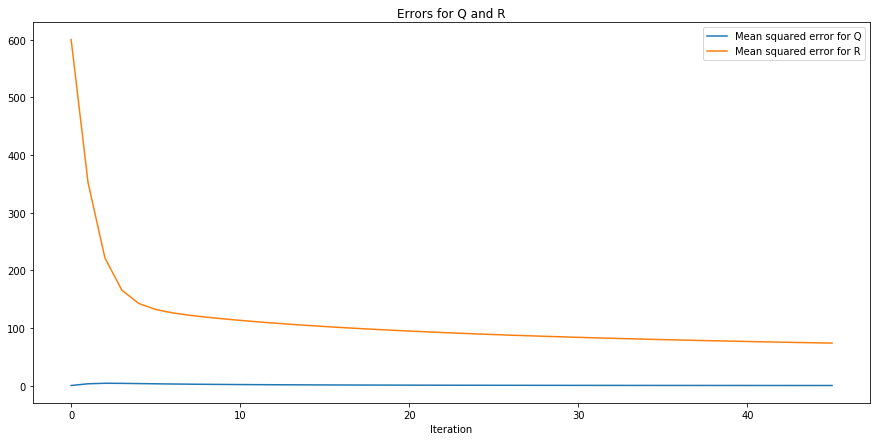

In [169]:
starting_point = [0,100, 10, 50] 


xs,ys = generate_trajectory(T,starting_point)
Qs,Rs, steps = em_algorithm(ys, starting_point, 100, 0.0001)
Q_last = Qs[:,:,-1]
R_last = Rs[:,:,-1]
print('True Q:\n{}\n\nQ from EM in {} steps:\n{}\n'.format(Q, steps, Q_last))
print('True R:\n{}\n\nR from EM in {} steps:\n{}\n'.format(R, steps, R_last))
err_q = ((Qs - Q[:,:,np.newaxis])**2).mean(axis=(0,1))
err_r = ((Rs - R[:,:,np.newaxis])**2).mean(axis=(0,1)) 
Q_best = Qs[:,:,np.argmin(err_q)]
print('True Q:\n{}\n\nBest Q from EM in {} steps:\n{}\n'.format(Q, steps, Q_best))


plt.figure(figsize=custom_figsize)
plt.title('Errors for Q and R')
plt.plot(np.arange(steps+1), err_q, label = 'Mean squared error for Q')
plt.plot(np.arange(steps+1), err_r, label = 'Mean squared error for R')
plt.xlabel('Iteration')
plt.legend()
plt.show()

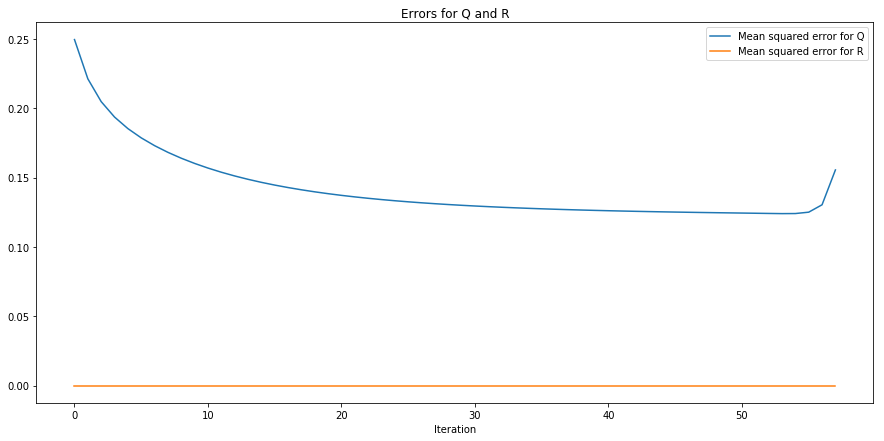

In [148]:
how_many=58
plt.figure(figsize=custom_figsize)
plt.title('Errors for Q and R')
plt.plot(np.arange(how_many), err_q[:how_many], label = 'Mean squared error for Q')
plt.plot(np.arange(how_many), err_r[:how_many], label = 'Mean squared error for R')
plt.xlabel('Iteration')
plt.legend()
plt.show()

('Inside kalman', 0.001)
('Inside kalman', 0.0020099800003999923)
('Inside kalman', 0.0030498983972963643)
('Inside kalman', 0.00413970788347549)
('Inside kalman', 0.005299350634571139)
('Inside kalman', 0.006548752920569164)
('Inside kalman', 0.007907818882107386)
('Inside kalman', 0.009396423212352227)
('Inside kalman', 0.011034402487151339)
Mean squared error for real and observed: 8.69008635668
Mean squared error for real and kalman: 7.11052407934
Mean squared error for real and rts: 6.96395077503


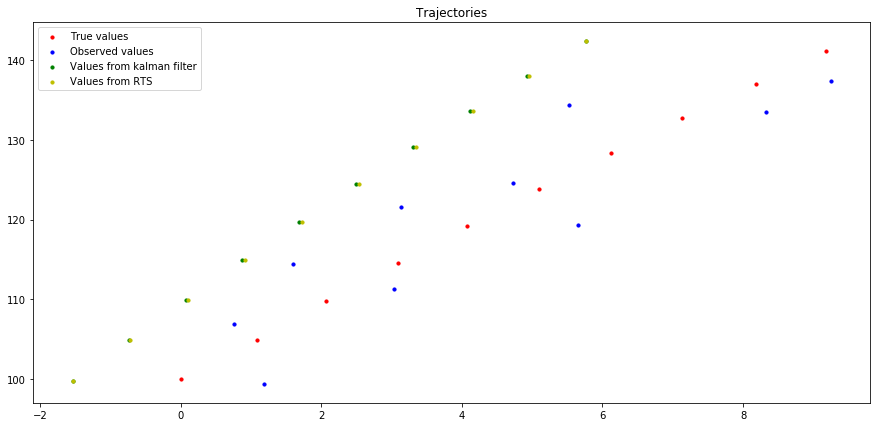

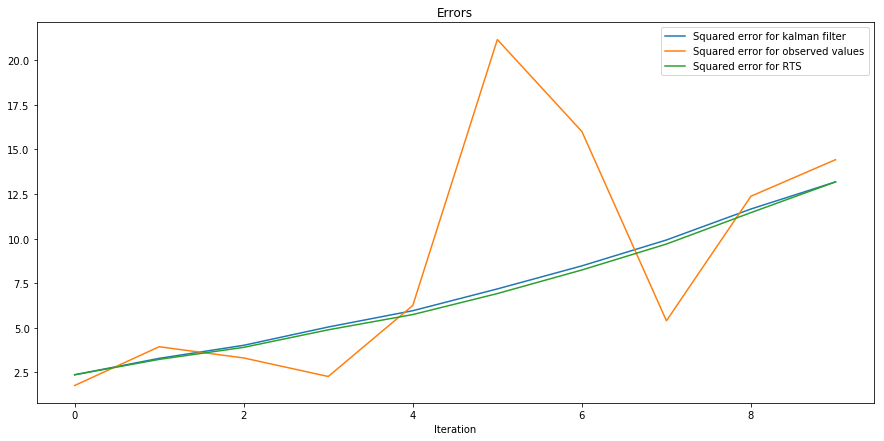

In [129]:
starting_point = [0,100, 10, 50] 


xs,ys = generate_trajectory(T,starting_point)


#kalman filter
kalman_start = np.random.multivariate_normal(starting_point, np.eye(4) * 10)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered = kalman_filter(ys, kalman_start, Q, R)
rts_xs, rts_covs, rts_ls = rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered)

err_kal = np.sum((xs[:2,:]-kalman_xs[:2,:])**2,axis=0)
err_y = np.sum((xs[:2,:]-ys)**2,axis=0)
err_rts = np.sum((xs[:2,:]-rts_xs[:2,:])**2,axis=0)

print('Mean squared error for real and observed: {}'.format(mse(xs[:2,:],ys)))
print('Mean squared error for real and kalman: {}'.format(mse(xs[:2,:], kalman_xs[:2,:])))
print('Mean squared error for real and rts: {}'.format(mse(xs[:2,:], rts_xs[:2,:])))





plt.figure(1, figsize=custom_figsize)
plt.title('Trajectories')
plt.scatter(xs[0,start_ind:],xs[1,start_ind:],c='r',s=dot_size, label='True values')
plt.scatter(ys[0,start_ind:],ys[1,start_ind:],c='b',s=dot_size, label='Observed values')
plt.scatter(kalman_xs[0,start_ind:], kalman_xs[1,start_ind:], c='g', s=dot_size, label='Values from kalman filter')
plt.scatter(rts_xs[0,start_ind:], rts_xs[1,start_ind:], c='y', s=dot_size, label='Values from RTS')
plt.legend()

plt.figure(2, figsize=custom_figsize)
plt.title('Errors')
plt.plot(np.arange(T), err_kal, label = 'Squared error for kalman filter')
plt.plot(np.arange(T), err_y, label = 'Squared error for observed values')
plt.plot(np.arange(T), err_rts, label = 'Squared error for RTS')
plt.xlabel('Iteration')
plt.legend()
plt.show()


In [114]:
# Test einsum xs
tmp_xs = kalman_xs.reshape(4,1,T)
x = np.einsum('ij...,lj...->il...',tmp_xs, tmp_xs)
x2 = np.einsum('ijk,ljk->ilk', tmp_xs, tmp_xs)
y = np.einsum('ijk,ljk->ilk', kalman_covs, kalman_covs)
test = True
for ind in range(T):
    test = test and (all(x[:,:,ind] == np.dot(tmp_xs[:,:,ind], tmp_xs[:,:,ind].T)) and all(np.dot(tmp_xs[:,:,ind], tmp_xs[:,:,ind].T) == x2[:,:,ind]))
print('Is test result for xs good?: {}'.format(test))
test = True
for ind in range(T):
    test = test and all(np.abs(y[:,:,ind] - np.dot(kalman_covs[:,:,ind], kalman_covs[:,:,ind].T)) < 10**(-10))
print('Is test result for covs good?: {}'.format(test))

Is test result for xs good?: True
Is test result for covs good?: True
